#### Installation

!pip install --no-cache-dir pandas numpy scikit-learn matplotlib seaborn jupyterlab \
torch torchvision transformers datasets accelerate trl wandb peft pillow bitsandbytes

#### Dependancies

In [1]:
import torch
import wandb
from torch.utils.data import random_split
from transformers import TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig
from peft.utils import prepare_model_for_kbit_training
from transformers import BitsAndBytesConfig
from transformers import LlavaOnevisionForConditionalGeneration
from transformers import AutoProcessor

import warnings
warnings.filterwarnings("ignore")

from mimic_dataset import MIMICDataset
from llava_dataset import LLaVAOneVisionDataset
from data_collator import LLaVADataCollator

### Load the Dataset

In [2]:
model_name = "../models/llava-onevision-qwen2-7b-ov-hf"
processor = AutoProcessor.from_pretrained(model_name, use_fast=True)
tokenizer = processor.tokenizer

base_ds = MIMICDataset(dataset_csv="../data/data_1k.csv")
full_ds = LLaVAOneVisionDataset(base_ds, processor, max_length=4096, mode="report")
train_size = int(0.9 * len(full_ds))
train_ds, eval_ds = random_split(full_ds, [train_size, len(full_ds) - train_size])

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
2025-05-31 14:54:48,437 - INFO - Loading dataset table from ../data/data_1k.csv
2025-05-31 14:54:48,447 - INFO - Initial dataset size: 1000
2025-05-31 14:54:50,741 - INFO - Filtered out 547 entries with empty or problematic reports.
2025-05-31 14:54:50,742 - INFO - Final dataset size: 453


In [3]:
for i in range(1):
    sample = train_ds[i]
    print(f"Sample {i}:")
    print(f"Pixel Values Shape: {sample['pixel_values'].shape}")
    print(f"Image Sizes: {sample['image_sizes']}")
    print("Chexpert_labels:", sample["chexpert_labels"].shape, sample["chexpert_labels"])

    # Decode input_ids
    input_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
    print(f"\nDecoded Input Text:\n{input_text}")

    # Decode labels (replace -100 with pad_token_id for decoding)
    labels_for_decoding = sample['labels'].clone()
    labels_for_decoding[labels_for_decoding == -100] = tokenizer.pad_token_id
    label_text = tokenizer.decode(labels_for_decoding, skip_special_tokens=True)
    print(f"\nDecoded Label Text:\n{label_text}")

Sample 0:
Pixel Values Shape: torch.Size([5, 3, 384, 384])
Image Sizes: tensor([764, 636])
Chexpert_labels: torch.Size([14]) tensor([-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.])

Decoded Input Text:
user 

Analyze the provided chest X-ray and generate a valid radiology report in professional clinical language. The report must include two sections:

Findings: A visual description of the anatomical structures and any abnormalities visible on the image. Use objective, medically appropriate terminology. Do not interpret beyond what is visible.

Impression: A brief summary emphasizing clinically significant findings.

Base the report solely on the image provided.
assistant 
Findings: Lung volumes are low. Heart size is mildly enlarged. The mediastinal and hilar contours relatively unchanged. No pulmonary vascular congestion is noted. Small right pleural effusion appears new compared to the prior exam. There is also a small amount of fluid within the right minor fis

### Test DataCollator

In [4]:
# Create data collator
data_collator = LLaVADataCollator(
    tokenizer=processor.tokenizer,
    padding=True,
    max_length=4096
)

# Test with a small batch
batch_size = 3
samples = [full_ds[i] for i in range(batch_size)]

print("Before collation:")
for i, sample in enumerate(samples):
    print(f"Sample {i}:")
    print(f"  input_ids shape: {sample['input_ids'].shape}")
    print(f"  attention_mask shape: {sample['attention_mask'].shape}")
    print(f"  labels shape: {sample['labels'].shape}")
    print(f"  pixel_values shape: {sample['pixel_values'].shape}")
    print(f"  image_sizes shape: {sample['image_sizes'].shape}")
    print(f"  chexpert_labels shape: {sample['chexpert_labels'].shape}")
    print()

# Apply data collator
print("Applying data collator...")
batch = data_collator(samples)

print("\nAfter collation:")
print(f"Batch keys: {list(batch.keys())}")
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")
        print(f"{key} dtype: {value.dtype}")
    else:
        print(f"{key}: {type(value)}")

# Verify all sequences have same length
input_ids = batch['input_ids']
attention_mask = batch['attention_mask']
labels = batch['labels']

print(f"\nValidation:")
print(f"All input_ids have same length: {all(len(seq) == len(input_ids[0]) for seq in input_ids)}")
print(f"All attention_masks have same length: {all(len(seq) == len(attention_mask[0]) for seq in attention_mask)}")
print(f"All labels have same length: {all(len(seq) == len(labels[0]) for seq in labels)}")

# Check padding tokens
pad_token_id = processor.tokenizer.pad_token_id
print(f"Pad token ID: {pad_token_id}")

# Check for proper masking in labels
for i in range(batch_size):
    num_neg100 = (labels[i] == -100).sum().item()
    num_padding = (input_ids[i] == pad_token_id).sum().item()
    print(f"Sample {i}: {num_neg100} masked tokens, {num_padding} padding tokens")

print("\nData collator test completed successfully!")

Before collation:
Sample 0:
  input_ids shape: torch.Size([4096])
  attention_mask shape: torch.Size([4096])
  labels shape: torch.Size([4096])
  pixel_values shape: torch.Size([5, 3, 384, 384])
  image_sizes shape: torch.Size([2])
  chexpert_labels shape: torch.Size([14])

Sample 1:
  input_ids shape: torch.Size([4096])
  attention_mask shape: torch.Size([4096])
  labels shape: torch.Size([4096])
  pixel_values shape: torch.Size([5, 3, 384, 384])
  image_sizes shape: torch.Size([2])
  chexpert_labels shape: torch.Size([14])

Sample 2:
  input_ids shape: torch.Size([4096])
  attention_mask shape: torch.Size([4096])
  labels shape: torch.Size([4096])
  pixel_values shape: torch.Size([5, 3, 384, 384])
  image_sizes shape: torch.Size([2])
  chexpert_labels shape: torch.Size([14])

Applying data collator...

After collation:
Batch keys: ['input_ids', 'attention_mask', 'labels', 'pixel_values', 'image_sizes', 'chexpert_labels']
input_ids shape: torch.Size([3, 4096])
input_ids dtype: torch.i

### Preparations

2025-05-31 14:57:17,623 - INFO - Loading dataset table from ../data/data_8k.csv
2025-05-31 14:57:17,675 - INFO - Initial dataset size: 8000
2025-05-31 14:57:34,691 - INFO - Filtered out 4256 entries with empty or problematic reports.
2025-05-31 14:57:34,692 - INFO - Final dataset size: 3744


Analyzing image resolutions...
Processed 0/3744 images
Processed 100/3744 images
Processed 200/3744 images
Processed 300/3744 images
Processed 400/3744 images
Processed 500/3744 images
Processed 600/3744 images
Processed 700/3744 images
Processed 800/3744 images
Processed 900/3744 images
Processed 1000/3744 images
Processed 1100/3744 images
Processed 1200/3744 images
Processed 1300/3744 images
Processed 1400/3744 images
Processed 1500/3744 images
Processed 1600/3744 images
Processed 1700/3744 images
Processed 1800/3744 images
Processed 1900/3744 images
Processed 2000/3744 images
Processed 2100/3744 images
Processed 2200/3744 images
Processed 2300/3744 images
Processed 2400/3744 images
Processed 2500/3744 images
Processed 2600/3744 images
Processed 2700/3744 images
Processed 2800/3744 images
Processed 2900/3744 images
Processed 3000/3744 images
Processed 3100/3744 images
Processed 3200/3744 images
Processed 3300/3744 images
Processed 3400/3744 images
Processed 3500/3744 images
Processed

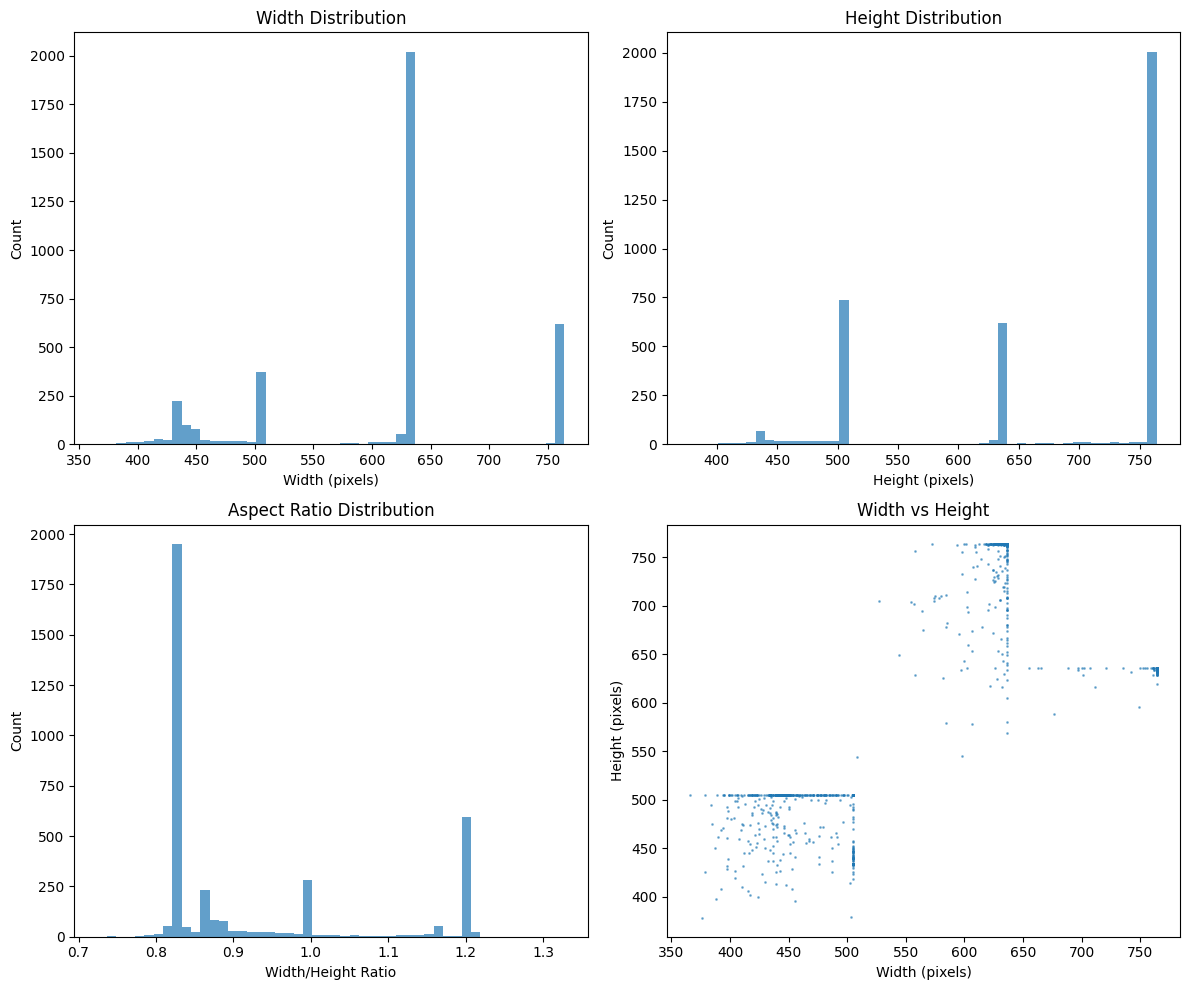


CROPPING STRATEGY SUGGESTIONS:

Most common width: 636 (1935 images)
Most common height: 764 (1967 images)

Minimum dimensions: 366x378
Suggested crop size: 366x378
Images that would need cropping: 3744/3744 (100.0%)


In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from mimic_dataset import MIMICDataset

def analyze_dataset_resolutions(dataset_path):
    """Analyze image resolutions in the dataset"""
    dataset = MIMICDataset(dataset_csv=dataset_path)
    
    resolutions = []
    widths = []
    heights = []
    aspect_ratios = []
    
    print("Analyzing image resolutions...")
    for i in range(len(dataset)):
        if i % 100 == 0:
            print(f"Processed {i}/{len(dataset)} images")
            
        image, _, _, _ = dataset[i]
        w, h = image.size
        
        resolutions.append((w, h))
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(w/h)
    
    # Count unique resolutions
    resolution_counts = Counter(resolutions)
    
    print(f"\nDataset Analysis Results:")
    print(f"Total images: {len(dataset)}")
    print(f"Unique resolutions: {len(resolution_counts)}")
    
    print(f"\nWidth statistics:")
    print(f"  Min: {min(widths)}, Max: {max(widths)}")
    print(f"  Most common widths: {Counter(widths).most_common(10)}")
    
    print(f"\nHeight statistics:")
    print(f"  Min: {min(heights)}, Max: {max(heights)}")
    print(f"  Most common heights: {Counter(heights).most_common(10)}")
    
    print(f"\nAspect ratio statistics:")
    print(f"  Min: {min(aspect_ratios):.3f}, Max: {max(aspect_ratios):.3f}")
    
    print(f"\nTop 20 most common resolutions:")
    for (w, h), count in resolution_counts.most_common(20):
        percentage = (count / len(dataset)) * 100
        print(f"  {w}x{h}: {count} images ({percentage:.1f}%)")
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Width distribution
    axes[0,0].hist(widths, bins=50, alpha=0.7)
    axes[0,0].set_title('Width Distribution')
    axes[0,0].set_xlabel('Width (pixels)')
    axes[0,0].set_ylabel('Count')
    
    # Height distribution
    axes[0,1].hist(heights, bins=50, alpha=0.7)
    axes[0,1].set_title('Height Distribution')
    axes[0,1].set_xlabel('Height (pixels)')
    axes[0,1].set_ylabel('Count')
    
    # Aspect ratio distribution
    axes[1,0].hist(aspect_ratios, bins=50, alpha=0.7)
    axes[1,0].set_title('Aspect Ratio Distribution')
    axes[1,0].set_xlabel('Width/Height Ratio')
    axes[1,0].set_ylabel('Count')
    
    # Resolution scatter plot
    axes[1,1].scatter(widths, heights, alpha=0.5, s=1)
    axes[1,1].set_title('Width vs Height')
    axes[1,1].set_xlabel('Width (pixels)')
    axes[1,1].set_ylabel('Height (pixels)')
    
    plt.tight_layout()
    plt.show()
    
    return resolution_counts, widths, heights, aspect_ratios


resolution_counts, widths, heights, aspect_ratios = analyze_dataset_resolutions("../data/data_8k.csv")

# Suggest cropping strategy
print(f"\n" + "="*60)
print("CROPPING STRATEGY SUGGESTIONS:")
print("="*60)

# Find common dimensions
width_counter = Counter(widths)
height_counter = Counter(heights)

most_common_width = width_counter.most_common(1)[0][0]
most_common_height = height_counter.most_common(1)[0][0]

print(f"\nMost common width: {most_common_width} ({width_counter[most_common_width]} images)")
print(f"Most common height: {most_common_height} ({height_counter[most_common_height]} images)")

# Check if we can crop to common size
min_width = min(widths)
min_height = min(heights)

print(f"\nMinimum dimensions: {min_width}x{min_height}")

# Suggest target sizes
target_width = min(most_common_width, min_width)
target_height = min(most_common_height, min_height)

print(f"Suggested crop size: {target_width}x{target_height}")

# Calculate how many images would need cropping
crop_needed = sum(1 for w, h in zip(widths, heights) if w > target_width or h > target_height)
print(f"Images that would need cropping: {crop_needed}/{len(widths)} ({crop_needed/len(widths)*100:.1f}%)")

### Training

In [5]:
ft_model_name = "llava-lora-qk-mm-crossqv-r32-PA"
wandb.init(project="LLaVA-OneVision Fine-tuning", name=ft_model_name)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model = LlavaOnevisionForConditionalGeneration.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
)

lora_config = LoraConfig(
        r=64,
        lora_alpha=64,
        target_modules=["q_proj", "v_proj", #"k_proj", 
                        #"dense_h_to_4h",
                        #"dense_4h_to_h",
                        "mm_projector",
                        "cross_attn.q_proj", "cross_attn.v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
model.to("cuda")

training_args = TrainingArguments(
    output_dir="../models/llava-lora-output",
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    num_train_epochs=2,
    learning_rate=1e-5,
    warmup_steps=50,
    logging_steps=2,
    eval_strategy="steps",
    eval_steps=250,
    save_strategy="epoch",
    save_total_limit=2,
    report_to="wandb",
    remove_unused_columns=False,
    fp16=True,
    label_names=["labels"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor.tokenizer,
    data_collator=data_collator
)

trainer.train()
trainer.save_model(f"../models/{ft_model_name}")
wandb.finish()

wandb: Currently logged in as: bvasilyev01 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


2025-05-31 14:24:24,537 - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 27,852,800 || all params: 8,058,660,384 || trainable%: 0.3456


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


RuntimeError: stack expects each tensor to be equal size, but got [5, 3, 384, 384] at entry 0 and [3, 3, 384, 384] at entry 2